<a href="https://colab.research.google.com/github/AhrenSalazar/AI-CrossWord-Solver/blob/main/Final_Crossword-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gradio and scikit-learn
!pip install -q gradio
!pip install -q scikit-learn


In [ ]:
# Confirm TF version and TextVectorization availability
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
print("TensorFlow version:", tf.__version__)
print("TextVectorization loaded OK")


TensorFlow version: 2.19.0
TextVectorization loaded OK


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, time, math, pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Define the base directory for saving model artifacts
BASE_DIR = '/content/drive/MyDrive/crossword_model'
# Create the directory if it doesn't already exist
os.makedirs(BASE_DIR, exist_ok=True)

# Define the path to the CSV dataset (change if needed)
CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/nytcrosswords.csv'
# Set the save directory for models and other files
SAVE_DIR = BASE_DIR

# Hyperparameters
# Batch size for training
BATCH_SIZE = 128
# Number of training epochs
EPOCHS = 20
# Dimension of the encoder embedding layer
ENC_EMB_DIM = 256
# Dimension of the decoder embedding layer
DEC_EMB_DIM = 256
# Number of units in the encoder LSTM layer
ENC_UNITS = 512
# Number of units in the decoder LSTM layer
DEC_UNITS = 512
# Maximum number of tokens (word-level) for a clue sequence
CLUE_SEQ_LEN = 40
# Maximum characters allowed in an answer (excluding Start/End of Sequence tokens)
ANS_MAX = 12
# Full sequence length for answers, including SOS and EOS tokens
ANS_SEQ_LEN = ANS_MAX + 2
# Length of decoder inputs (SOS + up to ANS_MAX characters), equals ANS_MAX + 1
DECODER_INPUT_LEN = ANS_SEQ_LEN - 1
print("DECODER_INPUT_LEN:", DECODER_INPUT_LEN)


DECODER_INPUT_LEN: 13


In [ ]:
df = pd.read_csv(CSV_PATH, encoding='latin1')
df = df.dropna(subset=["Word","Clue"])
df['input_text'] = df['Clue'].astype(str).str.lower().str.strip()
df['target_text'] = df['Word'].astype(str).str.upper().str.strip()

# Filter very long answers or empty entries
df = df[df['input_text'].str.len() > 0]
df = df[df['target_text'].str.len() > 0]
df = df[df['target_text'].str.len() <= ANS_MAX]  # keep answers of reasonable length

print("Total rows after filtering:", len(df))
train_df, val_df = train_test_split(df[['input_text','target_text']], test_size=0.05, random_state=42)
print("Train size:", len(train_df), "Val size:", len(val_df))


Total rows after filtering: 777503
Train size: 738627 Val size: 38876


In [ ]:
# Clue vectorizer: word-level tokens
# Converts clue text into sequences of integer word IDs.
clue_vectorizer = TextVectorization(
    output_mode='int',  # Output integer indices for words
    output_sequence_length=CLUE_SEQ_LEN,  # Pad/truncate sequences to this length
    standardize='lower_and_strip_punctuation' # Convert text to lowercase and remove punctuation
)
clue_vectorizer.adapt(train_df['input_text'].values) # Learns the vocabulary from the training clues

# Define a named function for standardization to avoid lambda serialization warning
def answer_standardize_fn(s):
    return tf.strings.strip(s)

# Answer vectorizer: character-level with explicit vocabulary (special tokens first)
# Converts answer characters into sequences of integer character IDs.
chars = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'-.")  # Define allowed characters
ans_vocab = ['[UNK]','[SOS]','[EOS]'] + chars # Create the full vocabulary including special tokens
answer_vectorizer = TextVectorization(
    output_mode='int', # Output integer indices for characters
    split='character', # Split input strings into individual characters
    output_sequence_length=ANS_SEQ_LEN, # Pad/truncate sequences to this length
    standardize=answer_standardize_fn # Use the named function instead of lambda
)
answer_vectorizer.set_vocabulary(ans_vocab) # Manually set the vocabulary to include special tokens and chars

print("Clue vocab size:", len(clue_vectorizer.get_vocabulary()))
print("Answer vocab size:", len(answer_vectorizer.get_vocabulary()))

Clue vocab size: 86517
Answer vocab size: 44


In [ ]:
# answer_vectorizer.get_vocabulary()

# Create a dictionary mapping integer IDs to tokens (characters)
# From the vocabulary of the answer_vectorizer.
idx_to_token = {i: t for i, t in enumerate(answer_vectorizer.get_vocabulary())}
# Maps the integer ID of each character back to its character string.

# Create a dictionary mapping tokens (characters) to their integer IDs
# This is the inverse of idx_to_token.
token_to_idx = {t: i for i, t in idx_to_token.items()}

# Define special token IDs for Start Of Sequence, End Of Sequence, and Unknown characters
SOS = token_to_idx['[SOS]'] # Integer ID for the Start Of Sequence token
EOS = token_to_idx['[EOS]'] # Integer ID for the End Of Sequence token
UNK = token_to_idx['[UNK]'] # Integer ID for the Unknown token

def answers_to_seq(arr):
    """
    Convert array-like of uppercase answer strings to fixed-length int sequences:
    Each sequence = [SOS] + chars + [EOS] then padded/truncated to ANS_SEQ_LEN.
    Returns numpy array shape (N, ANS_SEQ_LEN)
    """
    seqs = []
    for s in arr:
        # Convert answer to uppercase string and remove leading/trailing whitespace
        s = str(s).strip().upper()
        # Convert the answer string into a list of individual characters
        chars_list = list(s)
        # Construct the sequence: start with SOS, map each character to its ID (or UNK if not found),
        # then append EOS.
        seq = [SOS] + [token_to_idx.get(c, UNK) for c in chars_list] + [EOS]

        # Pad or truncate the sequence to the predefined ANS_SEQ_LEN
        if len(seq) < ANS_SEQ_LEN:
            # If shorter, pad with zeros until it reaches ANS_SEQ_LEN
            seq = seq + [0] * (ANS_SEQ_LEN - len(seq))
        else:
            # If longer, truncate to ANS_SEQ_LEN
            seq = seq[:ANS_SEQ_LEN]
        seqs.append(seq)
    # Convert the list of integer sequences into a NumPy array with int32 data type
    return np.array(seqs, dtype=np.int32)

In [ ]:
def format_dataset(df_in, batch=BATCH_SIZE, shuffle=True):
    # Vectorize clues using the pre-trained clue_vectorizer
    clues = clue_vectorizer(np.array(df_in['input_text'].astype(str)))

    # Convert answer strings to integer sequences using answers_to_seq function
    answers_seq = answers_to_seq(df_in['target_text'].astype(str).values)  # shape (N, ANS_SEQ_LEN)

    # Prepare decoder input and target sequences
    # Decoder input is the answer sequence shifted by one token to the left (starts with SOS, ends before EOS)
    decoder_input = answers_seq[:, :-1]   # (batch, dec_len)
    # Decoder target is the answer sequence shifted by one token to the right (starts after SOS, ends with EOS)
    decoder_target = answers_seq[:, 1:]   # (batch, dec_len)

    # Convert decoder target to a TensorFlow tensor with int32 dtype
    # This removes any potential extra dimension if it was added implicitly and ensures correct dtype
    decoder_target = tf.convert_to_tensor(decoder_target, dtype=tf.int32)

    # Create a TensorFlow Dataset from the processed clues, decoder inputs, and decoder targets
    # The dataset yields tuples of ((encoder_input, decoder_input), decoder_target)
    ds = tf.data.Dataset.from_tensor_slices(((clues, decoder_input), decoder_target))

    # Shuffle the dataset probably not total required though
    if shuffle:
        ds = ds.shuffle(20000)

    # Batch the dataset and prefetch elements for performance optimization
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

# Create training and validation datasets
train_ds = format_dataset(train_df, batch=BATCH_SIZE, shuffle=True)
val_ds = format_dataset(val_df, batch=BATCH_SIZE, shuffle=False)

print("Train ds example batch shapes:")
# Take one batch from the training dataset and print the shapes of its components
for (x,y), t in train_ds.take(1):
    print("encoder_input:", x.shape,
          "decoder_input:", y.shape,
          "decoder_target:", t.shape)

Train ds example batch shapes:
encoder_input: (128, 40) decoder_input: (128, 13) decoder_target: (128, 13)


In [ ]:
# Redeclare ENC_UNITS and DEC_UNITS because kept running into a weird bug

# Encoder and Decoder units are reset to ensure consistency if previous cells modified them.
ENC_UNITS = 256
DEC_UNITS = 256

# Encoder
# Input layer for the encoder, expecting a sequence of clue token IDs
encoder_inputs = Input(shape=(CLUE_SEQ_LEN,), dtype='int32', name='encoder_inputs')
# Embedding layer for encoder inputs, converting token IDs to dense vectors
enc_emb = Embedding(
    input_dim=len(clue_vectorizer.get_vocabulary()), # Size of the vocabulary
    output_dim=ENC_EMB_DIM,                          # Dimension of the embedding vectors
    mask_zero=True,                                  # Enable masking for padded zeros
    name='enc_emb'
)(encoder_inputs)

# Encoder LSTM layer: processes the embedded clue sequence
# return_sequences=True to get hidden states for all time steps (for attention)
# return_state=True to get final hidden and cell states (to initialize decoder)
# use_cudnn=False to avoid cuDNN-related masking issues
encoder_lstm = LSTM(ENC_UNITS, return_sequences=True, return_state=True, name='encoder_lstm', use_cudnn=False)
enc_outputs, enc_state_h, enc_state_c = encoder_lstm(enc_emb)

# Decoder
# Input layer for the decoder, expecting a sequence of answer character IDs (shifted)
decoder_inputs = Input(shape=(DECODER_INPUT_LEN,), dtype='int32', name='decoder_inputs')
# Embedding layer for decoder inputs, converting character IDs to dense vectors
dec_emb = Embedding(
    input_dim=len(answer_vectorizer.get_vocabulary()), # Size of the vocabulary
    output_dim=DEC_EMB_DIM,                            # Dimension of the embedding vectors
    mask_zero=True,                                    # Enable masking for padded zeros
    name='dec_emb'
)(decoder_inputs)

# Decoder LSTM layer: processes the embedded answer sequence
# return_sequences=True to get hidden states for all time steps (for attention)
# Initial state is set from the encoder's final states (h and c)
# use_cudnn=False to avoid cuDNN-related masking issues
decoder_lstm = LSTM(DEC_UNITS, return_sequences=True, return_state=True, name='decoder_lstm', use_cudnn=False)
dec_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[enc_state_h, enc_state_c])

#### Attention part ####
# Additive Attention layer to compute context vectors
attn = AdditiveAttention(name='attention_layer')

# Explicitly expand the encoder mask to (batch, 1, clue_seq_len) for broadcasting compatibility
# This is a specific fix for a known issue with AdditiveAttention and masking in TF 2.19
expanded_enc_mask = tf.keras.ops.expand_dims(enc_emb._keras_mask, axis=1)

# Calculate context vector: combines decoder outputs (query) and encoder outputs (value)
# Masks are applied to ignore padded tokens during attention calculation
context = attn(
    [dec_outputs, enc_outputs],
    mask=[dec_emb._keras_mask, expanded_enc_mask]   # Pass decoder and expanded encoder masks
)

# Output layer
# Concatenate the context vector with the decoder's hidden states
concat = Concatenate(axis=-1, name='concat_layer')([context, dec_outputs])
# Dense output layer predicts the probability distribution over the answer vocabulary
decoder_dense = Dense(len(answer_vectorizer.get_vocabulary()), activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(concat)

# Training model
# Define the full training model: takes encoder and decoder inputs, outputs decoder predictions
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Compile the model with Adam optimizer and sparse categorical crossentropy loss
training_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
# Print a summary of the model architecture
training_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_emb (Embedding) │ (None, 40, 256)   │ 22,148,352 │ encoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_11        │ (None, 40)        │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_emb (Embedding) │ (None, 13, 256)   │     11,264 │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 40, 256), │    525,312 │ enc_emb[0][0],    │
│                     │ (None, 256),      │            │ not_equal_11[0][… │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 13, 256), │    525,312 │ dec_emb[0][0],    │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (None, 13)        │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims_18      │ (None, 1, 40)     │          0 │ not_equal_11[0][… │
│ (ExpandDims)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 13, 256)   │        256 │ decoder_lstm[0][… │
│ (AdditiveAttention) │                   │            │ encoder_lstm[0][… │
│                     │                   │            │ not_equal_12[0][… │
│                     │                   │            │ expand_dims_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 13, 512)   │          0 │ attention_layer[… │
│ (Concatenate)       │                   │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 13, 44)    │     22,572 │ concat_layer[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,233,068 (88.63 MB)

 Trainable params: 23,233,068 (88.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Training!

checkpoint_path = os.path.join(SAVE_DIR, 'best_weights.weights.h5')  # must end with .weights.h5
checkpoint_cb = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

start = time.time()
history = training_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[checkpoint_cb, reduce_lr])
print("Training time (s):", time.time() - start)

# Save final weights
training_model.save_weights(os.path.join(SAVE_DIR, 'final_weights.weights.h5'))
print("Saved best weights to", checkpoint_path)


Epoch 1/20
5771/5771 ━━━━━━━━━━━━━━━━━━━━ 164s 27ms/step - loss: 1.8997 - sparse_categorical_accuracy: 0.2628 - val_loss: 1.4723 - val_sparse_categorical_accuracy: 0.3205 - learning_rate: 0.0010
Epoch 2/20
5771/5771 ━━━━━━━━━━━━━━━━━━━━ 151s 26ms/step - loss: 1.3565 - sparse_categorical_accuracy: 0.3240 - val_loss: 1.3185 - val_sparse_categorical_accuracy: 0.3241 - learning_rate: 0.0010
Epoch 3/20
5771/5771 ━━━━━━━━━━━━━━━━━━━━ 150s 26ms/step - loss: 1.1172 - sparse_categorical_accuracy: 0.3511 - val_loss: 1.2656 - val_sparse_categorical_accuracy: 0.3339 - learning_rate: 0.0010
Epoch 4/20
5771/5771 ━━━━━━━━━━━━━━━━━━━━ 150s 26ms/step - loss: 0.9593 - sparse_categorical_accuracy: 0.3727 - val_loss: 1.2490 - val_sparse_categorical_accuracy: 0.3414 - learning_rate: 0.0010
Epoch 5/20
5771/5771 ━━━━━━━━━━━━━━━━━━━━ 147s 25ms/step - loss: 0.8439 - sparse_categorical_accuracy: 0.3903 - val_loss: 1.2616 - val_sparse_categorical_accuracy: 0.3462 - learning_rate: 0.0010
Epoch 6/20
5771/5771 ━━━━

In [ ]:
#Saving weights + vectors
with open(os.path.join(SAVE_DIR, 'clue_vocab.pkl'), 'wb') as f:
    pickle.dump(clue_vectorizer.get_vocabulary(), f)
with open(os.path.join(SAVE_DIR, 'answer_vocab.pkl'), 'wb') as f:
    pickle.dump(answer_vectorizer.get_vocabulary(), f)

print("Saved vectorizer vocabularies to", SAVE_DIR)
checkpoint_path = os.path.join(SAVE_DIR, 'best_weights.weights.h5') # Re-define checkpoint_path
print("Best weights:", checkpoint_path)

Saved vectorizer vocabularies to /content/drive/MyDrive/crossword_model
Best weights: /content/drive/MyDrive/crossword_model/best_weights.weights.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, AdditiveAttention, Concatenate # Added Input here

# Rebuild training architecture
# (redeclare inputs, layers variable names to allow layer lookup and reuse)

# Encoder (matching the training model for weight loading)
encoder_inputs = Input(shape=(CLUE_SEQ_LEN,), dtype='int32', name='encoder_inputs')
enc_emb = Embedding(input_dim=len(clue_vectorizer.get_vocabulary()), output_dim=ENC_EMB_DIM, mask_zero=True, name='enc_emb')(encoder_inputs)
# Note: use_cudnn=False is implicitly handled if not specified, as weights are loaded
encoder_lstm = LSTM(ENC_UNITS, return_sequences=True, return_state=True, name='encoder_lstm')
enc_outputs, enc_state_h, enc_state_c = encoder_lstm(enc_emb)

# Decoder (matching the training model for weight loading)
decoder_inputs = Input(shape=(DECODER_INPUT_LEN,), dtype='int32', name='decoder_inputs')
dec_emb_layer = Embedding(input_dim=len(answer_vectorizer.get_vocabulary()), output_dim=DEC_EMB_DIM, mask_zero=True, name='dec_emb')
dec_emb = dec_emb_layer(decoder_inputs)
# Note: use_cudnn=False is implicitly handled if not specified, as weights are loaded
decoder_lstm = LSTM(DEC_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
dec_lstm_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[enc_state_h, enc_state_c])

attn = AdditiveAttention(name='attention_layer') # Changed to AdditiveAttention
# Explicitly expand the encoder mask to (batch, 1, clue_seq_len) for broadcasting compatibility
expanded_enc_mask = tf.keras.ops.expand_dims(enc_emb._keras_mask, axis=1)

context = attn(
    [dec_lstm_outputs, enc_outputs],
    mask=[dec_emb._keras_mask, expanded_enc_mask]   # Pass decoder and expanded encoder masks
)
concat = Concatenate(axis=-1, name='concat_layer')([context, dec_lstm_outputs])
decoder_dense = Dense(len(answer_vectorizer.get_vocabulary()), activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(concat)

# Construct the training model again with named layers to load weights correctly
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='training_model')

# Load best weights into the rebuilt training model
weights_path = os.path.join(SAVE_DIR, 'best_weights.weights.h5') # Fixed: added '.weights' to the filename
training_model.load_weights(weights_path)
print("Loaded weights from", weights_path)

# Build Encoder Model for Inference
# This model takes the clue input and outputs the encoder's final states and all hidden states (for attention)
encoder_model = Model(encoder_inputs, [enc_outputs, enc_state_h, enc_state_c])

# Build One-Step Decoder Model for Inference
# This model predicts one character at a time, taking the previously predicted character,
# the current decoder states, and the encoder outputs as input.
dec_token_input = Input(shape=(1,), dtype='int32', name='dec_token_input') # Input for a single token
dec_h_in = Input(shape=(DEC_UNITS,), name='dec_h_in') # Input for previous decoder hidden state
dec_c_in = Input(shape=(DEC_UNITS,), name='dec_c_in') # Input for previous decoder cell state
enc_outs_in = Input(shape=(CLUE_SEQ_LEN, ENC_UNITS), name='enc_outs_in') # Input for all encoder outputs (for attention)

# Reuse layers by name from the training_model to ensure same weights are used
dec_emb_layer = training_model.get_layer('dec_emb')
decoder_lstm_layer = training_model.get_layer('decoder_lstm')
decoder_dense_layer = training_model.get_layer('decoder_dense')
attention_layer = training_model.get_layer('attention_layer')

# Process single token through decoder embedding, LSTM, and attention
dec_emb_step = dec_emb_layer(dec_token_input)  # (batch,1,emb_dim)
dec_lstm_out_step, dec_h_out, dec_c_out = decoder_lstm_layer(dec_emb_step, initial_state=[dec_h_in, dec_c_in])  # (batch,1,dec_units)

# Apply attention: query=decoder output, value=encoder outputs
context_step = attention_layer([dec_lstm_out_step, enc_outs_in])  # (batch,1,enc_units)
# Concatenate context vector with decoder LSTM output
concat_step = Concatenate(axis=-1)([context_step, dec_lstm_out_step])  # (batch,1,enc+dec)
# Predict next token's probability distribution
preds_step = decoder_dense_layer(concat_step)  # (batch,1,vocab)

# Define the decoder model for inference
decoder_model = Model([dec_token_input, dec_h_in, dec_c_in, enc_outs_in],
                      [preds_step, dec_h_out, dec_c_out])

print("Built encoder_model and decoder_model for inference.")

Loaded weights from /content/drive/MyDrive/crossword_model/best_weights.weights.h5
Built encoder_model and decoder_model for inference.


In [ ]:
# Load vectorizer vocabularies, need to load these if you're in a new session
# and re-instantiate the vectorizer layers.

# First, re-define the standardization function as it's needed for TextVectorization initialization
def answer_standardize_fn(s):
    return tf.strings.strip(s)

# Load clue vocabulary
with open(os.path.join(SAVE_DIR, 'clue_vocab.pkl'), 'rb') as f:
    clue_vocab = pickle.load(f)
# Re-instantiate clue_vectorizer and set its vocabulary
clue_vectorizer = tf.keras.layers.TextVectorization(
    output_mode='int',
    output_sequence_length=CLUE_SEQ_LEN,
    standardize='lower_and_strip_punctuation'
)
clue_vectorizer.set_vocabulary(clue_vocab)

# Load answer vocabulary
with open(os.path.join(SAVE_DIR, 'answer_vocab.pkl'), 'rb') as f:
    answer_vocab = pickle.load(f)
# Re-instantiate answer_vectorizer and set its vocabulary
answer_vectorizer = tf.keras.layers.TextVectorization(
    output_mode='int',
    split='character',
    output_sequence_length=ANS_SEQ_LEN,
    standardize=answer_standardize_fn
)
answer_vectorizer.set_vocabulary(answer_vocab)

# Re-initialize token mappings after loading vectorizers
idx_to_token = {i: t for i, t in enumerate(answer_vectorizer.get_vocabulary())}
token_to_idx = {t: i for i, t in idx_to_token.items()}
SOS = token_to_idx['[SOS]']
EOS = token_to_idx['[EOS]']
UNK = token_to_idx['[UNK]']

def encode_clue(clue_text):
    """
    Encodes a single clue text using the encoder_model.
    Returns encoder outputs and the final hidden and cell states.
    """
    seq = clue_vectorizer([clue_text])  # shape (1, CLUE_SEQ_LEN)
    enc_outs, h, c = encoder_model.predict(seq, verbose=0)
    return enc_outs, h, c

import math
def beam_search(clue_text, beam_width=5, max_len=ANS_SEQ_LEN+1):
    """
    Performs beam search to decode the best possible answer for a given clue.
    """
    # Encode the input clue to get initial encoder states
    enc_outs, h, c = encode_clue(clue_text)
    # Initialize beams: (log_probability, token_sequence, decoder_h_state, decoder_c_state)
    beams = [(0.0, [SOS], h, c)]
    completed = [] # Stores completed sequences (ended with EOS)

    # Iterate for a maximum sequence length
    for _ in range(max_len):
        all_candidates = []
        for logp, seq, h_state, c_state in beams:
            # If the sequence is already completed, add to completed list and continue
            last = seq[-1]
            if last == EOS:
                completed.append((logp, seq))
                continue

            # Predict the next character distribution using the decoder model
            # Input: last predicted token, current decoder states, encoder outputs (for attention)
            preds, h_new, c_new = decoder_model.predict([np.array([[last]]), h_state, c_state, enc_outs], verbose=0)
            probs = preds[0,0,:]  # Get probabilities for the next token (shape: vocab_size)

            # Select top-k (beam_width) indices based on probabilities
            top_idxs = np.argpartition(-probs, beam_width)[:beam_width]

            # Create new candidates for the next beam
            for idx in top_idxs:
                p = probs[int(idx)]
                if p <= 0: # Avoid log of zero
                    continue
                # Calculate new log probability and new sequence
                cand = (logp + math.log(p + 1e-12), seq + [int(idx)], h_new, c_new)
                all_candidates.append(cand)

        # If no candidates are generated (e.g., all beams ended with EOS or invalid tokens),
        # break the loop
        if not all_candidates:
            break
        # Sort all candidates by log probability and select the top 'beam_width' for the next iteration
        all_candidates.sort(key=lambda x: x[0], reverse=True)
        beams = all_candidates[:beam_width]

    # Combine completed sequences with any remaining active beams
    final = completed + [(b[0], b[1]) for b in beams]
    # Sort all final sequences by log probability
    final.sort(key=lambda x: x[0], reverse=True)

    results = []
    for score, seq in final[:beam_width]:
        # Convert token IDs back to characters, stopping at EOS token
        toks = seq[1:]  # Drop SOS token
        chars = []
        for t in toks:
            if t == EOS:
                break
            # Get character from ID, handling unknown tokens
            token = idx_to_token.get(int(t), '')
            if token in ['[UNK]','[SOS]','[EOS]','[PAD]']:
                if token == '[UNK]':
                    chars.append('?') # Represent UNK as '?'
                continue
            chars.append(token)
        ans = ''.join(chars)
        results.append((score, ans))
    return results

# Quick test
print(beam_search("Sense of self", beam_width=5))

[(-1.2427852390237404, 'EGO'), (-3.9413668569570364, 'HER'), (-4.139175349213176, 'HEIR'), (-4.436224868166775, 'HEN'), (-5.380772020807043, 'HERE')]


In [ ]:
# Launch Demo

import gradio as gr

def gr_predict(clue, top_k=5):
    if not isinstance(clue, str) or clue.strip() == '':
        return "Please enter a clue."
    preds = beam_search(clue, beam_width=top_k)
    out = []
    for score, ans in preds:
        out.append(f"{ans}    (score: {score:.3f})")
    return "\n".join(out)

iface = gr.Interface(
    fn=lambda clue, k: gr_predict(clue, top_k=k),
    inputs=[gr.Textbox(lines=2, placeholder="Enter crossword clue..."), gr.Slider(1, 10, value=5, step=1, label="Top k")],
    outputs=gr.Textbox(label="Top-k predictions"),
    title="Crossword Clue Answer Generator",
    description="Seq2seq LSTM + Attention with beam search (top-k)."
)

# Launch
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3cccd8021cd624f1b0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


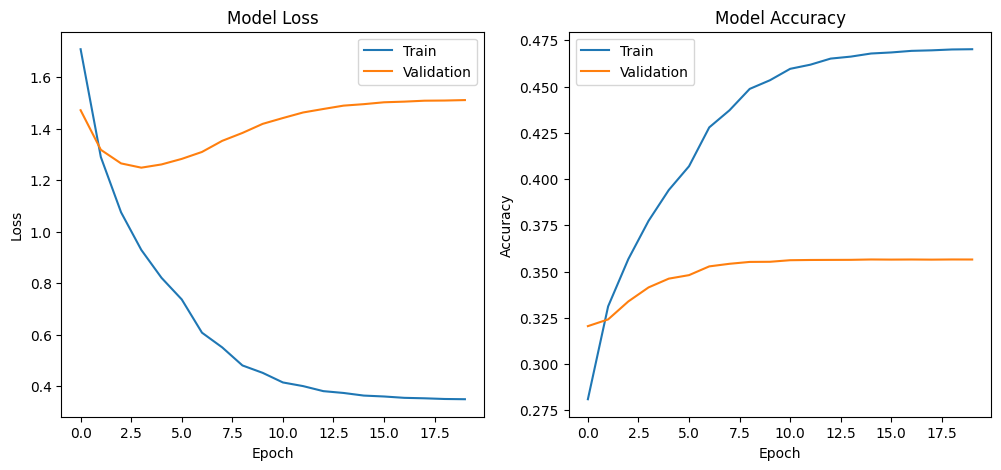

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' object from model.fit is still available
# If not, you might need to re-run the training cell to get it

if 'history' in locals():
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
else:
    print("Need to run training cell to get history.")